# ResNet Model Load Best Checkpoint Weights and Analyze on Test Set


## Connect to Data and Download Libaries


In [1]:
#Mount GoogleColab to Google Drive. Not a necessary step for those who store the data elsewhere.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Needed to plot the confusion matrices later
!pip install scikit-plot

### Download Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam


# Display
#from IPython.display import Image, display
from PIL import Image
import matplotlib.cm as cm


### Set Up Paths to Data and Check Number of Images

In [4]:
#Paths to data
train_path = '/content/gdrive/MyDrive/210_data/train'
validation_path = '/content/gdrive/MyDrive/210_data/val'
test_path = '/content/gdrive/MyDrive/210_data/test'

SIZE = 400
batch_size = 64

In [5]:
#Number of images in each set 
num_train_images = sum([len(files) for r, d, files in os.walk(train_path)])
num_val_images = sum([len(files) for r, d, files in os.walk(validation_path)])
num_test_images = sum([len(files) for r, d, files in os.walk(test_path)])
num_train_images + num_val_images + num_test_images #check sum adds to 18,365

18365

## Helper Functions

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2,8, figsize = (20,5))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Build Model

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
    rescale = 1./255,
    #these are the three methods mentioned in the paper for augmenting the images. Use these in second baseline model.
    rotation_range=359, 
    horizontal_flip= True, 
    vertical_flip=True,
    fill_mode='reflect'
)

In [8]:
validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

In [9]:
test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

In [10]:
train_generator = train_datagen.flow_from_directory(
        directory = train_path,  # this is the input directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')  # multiple categories

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 14687 images belonging to 15 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
    directory = validation_path,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 1828 images belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [12]:
test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 1850 images belonging to 15 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

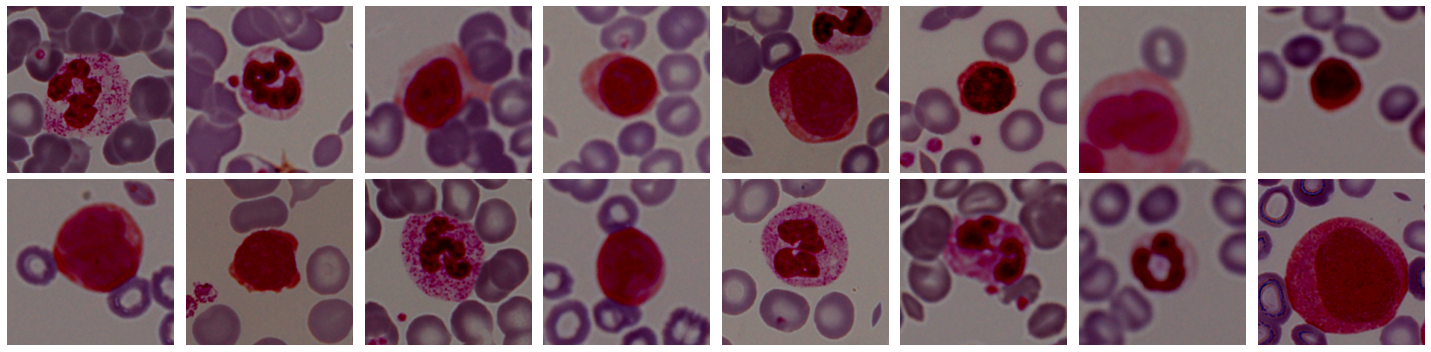

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

In [13]:
#Look at batch of train images
imgs, labels = next(train_generator)
plotImages(imgs)
print(labels)

In [14]:
#Import ResNet50 model from keras
model = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=None,
    input_shape=None, pooling=None, classes=15)

In [15]:
#Look at model structure 
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
#implement model.compile
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate = 0.0001),
              metrics=['accuracy'])

## Download Checkpoint for Best Saved Accuracy

For RestNet, this means downloading the 65th epoch out of the 100 epochs run.

In [17]:
#Load the model weights
model.load_weights('/content/gdrive/MyDrive/resnet_100_epoch_7_7_21/weights-improvement-65-0.96.hdf5')

In [18]:
#Print the accuracy and loss of the test data
loss,acc = model.evaluate(test_generator, batch_size = 64 , verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 - 493s - loss: 0.1744 - accuracy: 0.9551
Restored model, accuracy: 95.51%


In [19]:
#test predictions
test_predictions = model.predict(x = test_generator, verbose = 0)

In [20]:
test_dic = test_generator.class_indices
test_dic

{'BAS': 0,
 'EBO': 1,
 'EOS': 2,
 'KSC': 3,
 'LYA': 4,
 'LYT': 5,
 'MMZ': 6,
 'MOB': 7,
 'MON': 8,
 'MYB': 9,
 'MYO': 10,
 'NGB': 11,
 'NGS': 12,
 'PMB': 13,
 'PMO': 14}

In [21]:
inv_test_dic = inv_map = {v: k for k, v in test_dic.items()}
inv_test_dic

{0: 'BAS',
 1: 'EBO',
 2: 'EOS',
 3: 'KSC',
 4: 'LYA',
 5: 'LYT',
 6: 'MMZ',
 7: 'MOB',
 8: 'MON',
 9: 'MYB',
 10: 'MYO',
 11: 'NGB',
 12: 'NGS',
 13: 'PMB',
 14: 'PMO'}

In [22]:
def map_to_labels(array):
    labeled_array = []
    for integer in array:
        labeled_array.append(inv_test_dic[integer])
    return labeled_array

In [23]:
#Cell breakdown of different cell types
from sklearn.metrics import classification_report
target_names = ['BAS','EBO','EOS','KSC','LYA','LYT','MMZ','MOB','MON','MYB','MYO','NGB','NGS','PMB','PMO']
print(classification_report(test_generator.classes, np.argmax(test_predictions, axis = -1), target_names = target_names))

              precision    recall  f1-score   support

         BAS       1.00      0.56      0.71         9
         EBO       1.00      0.89      0.94         9
         EOS       1.00      0.91      0.95        43
         KSC       0.00      0.00      0.00         2
         LYA       0.00      0.00      0.00         2
         LYT       0.96      0.97      0.97       395
         MMZ       0.00      0.00      0.00         2
         MOB       0.00      0.00      0.00         4
         MON       0.90      0.92      0.91       180
         MYB       0.50      0.60      0.55         5
         MYO       0.93      0.95      0.94       328
         NGB       1.00      0.08      0.15        12
         NGS       0.98      1.00      0.99       849
         PMB       0.00      0.00      0.00         3
         PMO       0.67      0.57      0.62         7

    accuracy                           0.96      1850
   macro avg       0.60      0.50      0.52      1850
weighted avg       0.95   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


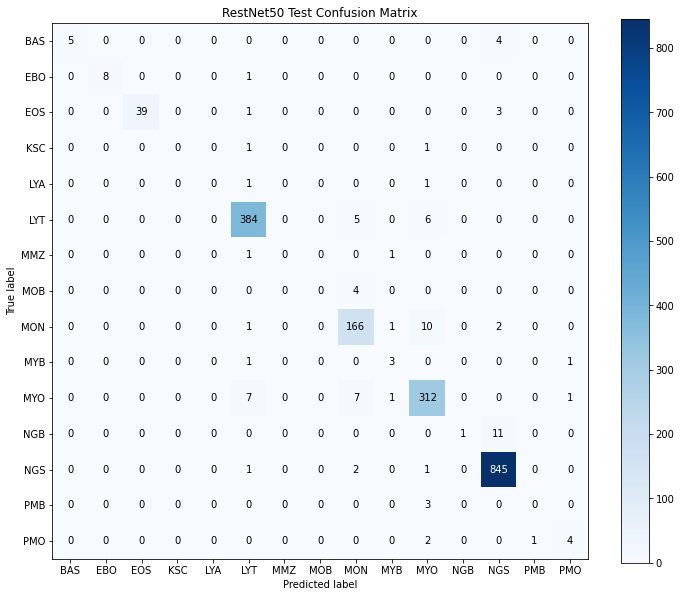

In [24]:
#Plot confusion matrix of different cell types for validation data
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    map_to_labels(test_generator.classes), 
    map_to_labels(np.argmax(test_predictions, axis = -1)),
    title = "RestNet50 Test Confusion Matrix",
    figsize=(12,10))

## Condense GRAD-Cam functions and apply to Multiple Images

In [25]:
#Import random to select random images per cell class for the heatmaps
import random

In [26]:
#Global variables for GRAD-Cam implementation
img_size = (224, 224)
preprocess_input = keras.applications.resnet50.preprocess_input
#decode_predictions = keras.applications.resnet50.decode_predictions
last_conv_layer_name = "conv5_block3_out"

In [27]:
# Remove last layer's softmax
model.layers[-1].activation = None

In [28]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [30]:
def make_gradcam(img_path, model, last_conv_layer_name, cam_path='', alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

In [ ]:
#Randomization Cell - Run ONLY once to get images to make heatmaps of.
file_list = []
for root, dirs, files in os.walk(validation_path, topdown=False):
    if root!= '/content/gdrive/MyDrive/210_data/val':
        chosen_image = random.choice(files)
        chosen_path = os.path.join(root, chosen_image)
        file_list.append(chosen_path)

In [ ]:
#Print the file_list and store for later use
file_list

['/content/gdrive/MyDrive/210_data/val/EOS/EOS_0037.tiff',
 '/content/gdrive/MyDrive/210_data/val/EBO/EBO_0052.tiff',
 '/content/gdrive/MyDrive/210_data/val/LYT/LYT_2635.tiff',
 '/content/gdrive/MyDrive/210_data/val/MYB/MYB_0025.tiff',
 '/content/gdrive/MyDrive/210_data/val/PMB/PMB_0013.tiff',
 '/content/gdrive/MyDrive/210_data/val/BAS/BAS_0014.tiff',
 '/content/gdrive/MyDrive/210_data/val/MOB/MOB_0022.tiff',
 '/content/gdrive/MyDrive/210_data/val/LYA/LYA_0006.tiff',
 '/content/gdrive/MyDrive/210_data/val/NGS/NGS_3112.tiff',
 '/content/gdrive/MyDrive/210_data/val/MMZ/MMZ_0012.tiff',
 '/content/gdrive/MyDrive/210_data/val/MYO/MYO_3174.tiff',
 '/content/gdrive/MyDrive/210_data/val/PMO/PMO_0049.tiff',
 '/content/gdrive/MyDrive/210_data/val/MON/MON_1119.tiff',
 '/content/gdrive/MyDrive/210_data/val/NGB/NGB_0040.tiff',
 '/content/gdrive/MyDrive/210_data/val/KSC/KSC_0012.tiff']

In [ ]:
#Makes heatmaps and saves them to superimposed_images folder
for img_path in file_list:
    cell_type = img_path.split("/")[-1][:3]
    make_gradcam(img_path, model, last_conv_layer_name,cam_path='/content/gdrive/MyDrive/superimposed_images/' + cell_type + ".tiff" , alpha=0.7)

In [ ]:
#Paths to superimposed images for plotting purposes
impose_images_paths = []
for file in os.listdir('/content/gdrive/MyDrive/superimposed_images'):
    impose_images_paths.append(os.path.join('/content/gdrive/MyDrive/superimposed_images',file))
impose_images_paths

['/content/gdrive/MyDrive/superimposed_images/EOS.tiff',
 '/content/gdrive/MyDrive/superimposed_images/EBO.tiff',
 '/content/gdrive/MyDrive/superimposed_images/LYT.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MYB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/PMB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/BAS.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MOB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/LYA.tiff',
 '/content/gdrive/MyDrive/superimposed_images/NGS.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MMZ.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MYO.tiff',
 '/content/gdrive/MyDrive/superimposed_images/PMO.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MON.tiff',
 '/content/gdrive/MyDrive/superimposed_images/NGB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/KSC.tiff']

In [ ]:
#Function to plot superimposed images
def plot_impose_Images(image_paths):
    fig, axes = plt.subplots(3,5, figsize = (10,5))
    axes = axes.flatten()
    for image_path, ax in zip(image_paths, axes):
        cell_type = image_path.split("/")[-1][:3]
        img = Image.open(image_path)
        ax.imshow(img)
        ax.title.set_text('Cell Type: ' + cell_type)
        ax.axis('off')
    plt.suptitle('ResNet Heatmap', y = 1.05, size = 16)
    plt.tight_layout()
    plt.show()

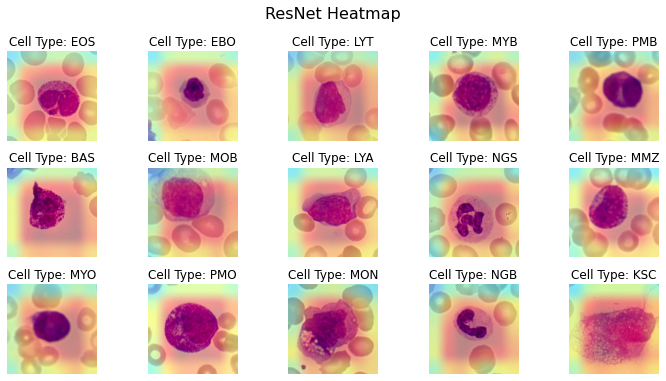

In [ ]:
#Make a heatmap grid of superimposed images
plot_impose_Images(impose_images_paths)

In [ ]:
#saved file list so we don't have to run randomization later
file_list = ['/content/gdrive/MyDrive/210_data/val/EOS/EOS_0037.tiff',
 '/content/gdrive/MyDrive/210_data/val/EBO/EBO_0052.tiff',
 '/content/gdrive/MyDrive/210_data/val/LYT/LYT_2635.tiff',
 '/content/gdrive/MyDrive/210_data/val/MYB/MYB_0025.tiff',
 '/content/gdrive/MyDrive/210_data/val/PMB/PMB_0013.tiff',
 '/content/gdrive/MyDrive/210_data/val/BAS/BAS_0014.tiff',
 '/content/gdrive/MyDrive/210_data/val/MOB/MOB_0022.tiff',
 '/content/gdrive/MyDrive/210_data/val/LYA/LYA_0006.tiff',
 '/content/gdrive/MyDrive/210_data/val/NGS/NGS_3112.tiff',
 '/content/gdrive/MyDrive/210_data/val/MMZ/MMZ_0012.tiff',
 '/content/gdrive/MyDrive/210_data/val/MYO/MYO_3174.tiff',
 '/content/gdrive/MyDrive/210_data/val/PMO/PMO_0049.tiff',
 '/content/gdrive/MyDrive/210_data/val/MON/MON_1119.tiff',
 '/content/gdrive/MyDrive/210_data/val/NGB/NGB_0040.tiff',
 '/content/gdrive/MyDrive/210_data/val/KSC/KSC_0012.tiff']